## 📘 **Applications of Explainable AI in Predictive Modelling**  
---

🏫 Week 12  
📅 Date: 2025-05-13  
🧑‍🏫 Irena Zimovska

---



## **Introduction to PyTorch**

In [1]:
# 1. Introduction to PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings


import matplotlib.pyplot as plt
import math
warnings.filterwarnings("ignore")

At its core, **PyTorch provides two main features**:

- An n-dimensional Tensor, similar to numpy but can run on GPUs

- Automatic differentiation for building and training neural networks

A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Behind the scenes, Tensors can keep track of a computational graph and gradients, but they’re also useful as a generic tool for scientific computing.

Also unlike numpy, PyTorch Tensors can utilize GPUs to accelerate their numeric computations. To run a PyTorch Tensor on GPU, you simply need to specify the correct device.

In [2]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [3]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [4]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.5038, 0.3146],
        [0.0821, 0.9552]]) 



In [5]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.9164, 0.3899, 0.3291],
        [0.2399, 0.4883, 0.0599]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [6]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## **Torch Device**

Within the PyTorch repo, we define an “Accelerator” as a torch.device that is being used alongside a CPU to speed up computation. These device use an asynchronous execution scheme, using torch.Stream and torch.Event as their main way to perform synchronization. We also assume that only one such accelerator can be available at once on a given host. This allows us to use the current accelerator as the default device for relevant concepts such as pinned memory, Stream device_type, FSDP, etc.

As of today, accelerator devices are (in no particular order) “CUDA”, “MTIA”, “XPU”, “MPS”, “HPU”, and PrivateUse1 (many device not in the PyTorch repo itself).


### **🚀 Accelerators** 

| Accelerator Type | Stands for                                    | Used for                                                                                    |
| :--------------- | :--------------------------------------------- | :------------------------------------------------------------------------------------------ |
| **CUDA**         | Nvidia GPUs (Graphics Processing Units)        | Most common for deep learning (Nvidia hardware).                                            |
| **MTIA**         | Meta Training and Inference Accelerator        | Facebook/Meta's custom chips for AI model acceleration.                                     |
| **XPU**          | Intel’s unified term (could be GPU, CPU, FPGA) | Intel’s way to abstract over different device types (especially their discrete GPUs).       |
| **MPS**          | Metal Performance Shaders                      | Apple’s GPU interface (macOS / iOS devices).                                                |
| **HPU**          | Habana Processing Unit (by Intel)              | Specialized AI chips like Gaudi (optimized for training/inference).                         |
| **PrivateUse1**  | Reserved for custom hardware                   | Devices outside PyTorch repo (e.g., specialized research hardware, startups' accelerators). |



In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


## **Torch Autograd**

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

PyTorch's *Autograd* feature is part of what make PyTorch flexible and fast for building machine learning projects. It allows for the rapid and easy computation of multiple partial derivatives (also referred to as *gradients)* over a complex computation. This operation is central to backpropagation-based neural network learning.

The power of autograd comes from the fact that it traces your computation dynamically *at runtime,* meaning that if your model has decision branches, or loops whose lengths are not known until runtime, the computation will still be traced correctly, and you'll get correct gradients to drive learning. This, combined with the fact that your models are built in Python, offers far more flexibility than frameworks that rely on static analysis of a more rigidly-structured model for computing gradients.

#### What Do We Need Autograd For?

A machine learning model is a *function*, with inputs and outputs. For this discussion, we'll treat the inputs a as an *i*-dimensional vector $\vec x$, with elements $x_{i}$. We can then express the model, *M*, as a vector-valued function of the input: *$\vec y$ = $\vec M$($\vec x$)*. (We treat the value of M's output as a vector because in general, a model may have any number of outputs.)

Since we'll mostly be discussing autograd in the context of training, our output of interest will be the model's loss. The *loss function* *L($\vec y$) = L($\vec M$($\vec x$))* is a single-valued scalar function of the model's output. This function expresses how far off our model's prediction was from a particular input's *ideal* output. *Note: After this point, we will often omit the vector sign where it should be contextually clear - e.g., $y$ instead of $\vec y$.*

In training a model, we want to minimize the loss. In the idealized case of a perfect model, that means adjusting its learning weights - that is, the adjustable parameters of the function - such that loss is zero for all inputs. In the real world, it means an iterative process of nudging the learning weights until we see that we get a tolerable loss for a wide variety of inputs.

How do we decide how far and in which direction to nudge the weights? We want to *minimize* the loss, which means making its first derivative with respect to the input equal to 0: $\frac{\partial L}{\partial x} = 0$.

Recall, though, that the loss is not *directly* derived from the input, but a function of the model's output (which is a function of the input directly), $\frac{\partial L}{\partial x}$ = $\frac{\partial {L({\vec y})}}{\partial x}$. By the chain rule of differential calculus, we have $\frac{\partial {L({\vec y})}}{\partial x}$ = $\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ = $\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$ is where things get complex. The partial derivatives of the model's outputs with respect to its inputs, if we were to expand the expression using the chain rule again, would involve many local partial derivatives over every multiplied learning weight, every activation function, and every other mathematical transformation in the model. The full expression for each such partial derivative is the sum of the products of the local gradient of *every possible path* through the computation graph that ends with the variable whose gradient we are trying to measure.

In particular, the gradients over the learning weights are of interest to us - they tell us *what direction to change each weight* to get the loss function closer to zero.

Since the number of such local derivatives (each corresponding to a separate path through the model's computation graph) will tend to go up exponentially with the depth of a neural network, so does the complexity in computing them. This is where autograd comes in: It tracks the history of every computation. Every computed tensor in your PyTorch model carries a history of its input tensors and the function used to create it. Combined with the fact that PyTorch functions meant to act on tensors each have a built-in implementation for computing their own derivatives, this greatly speeds the computation of the local derivatives needed for learning.

#### **Example 1**

In [8]:
def f(x): 
    return 3 * x **2 - 4 * x

def numerical_limit(f, x, h): 
    return (f(x+h) - f(x))/h

h = 0.1

for i in range(6): 
    print(f'h={h:.6f}, numerical limit = {numerical_limit(f, 1, h): .6f}')
    h *= 0.1

h=0.100000, numerical limit =  2.300000
h=0.010000, numerical limit =  2.030000
h=0.001000, numerical limit =  2.003000
h=0.000100, numerical limit =  2.000300
h=0.000010, numerical limit =  2.000030
h=0.000001, numerical limit =  2.000003


In [9]:
x = torch.arange(4.0, requires_grad=True)

# requires_grad = True means that PyTocrh should keep in mind 
# that we might further need a gradient with respect to X

x


tensor([0., 1., 2., 3.], requires_grad=True)

In [10]:
print(x.grad)

# The default value is None, the grad is not available YET

None


In [11]:
# Call the function - let's say a dot profuct of X
y = torch.dot(x, x)
print(y)

tensor(14., grad_fn=<DotBackward0>)


In [12]:
y.backward()

# In order to fint partial derivatives, you call method backward()
print(x.grad)

tensor([0., 2., 4., 6.])


In [13]:
print(2*x)

# So, the grad is exactly the values of the partial derivatives with x

tensor([0., 2., 4., 6.], grad_fn=<MulBackward0>)


In [14]:
# Remember to clear the x.grad as PyTorch accumulates the gradient by default
x.grad.zero_()

tensor([0., 0., 0., 0.])

#### **Example 2**

We'll create an input tensor full of evenly spaced values on the interval $[0, 2{\pi}]$, and specify `requires_grad=True`. (Like most functions that create tensors, `torch.linspace()` accepts an optional `requires_grad` option.) Setting this flag means that in every computation that follows, autograd will be accumulating the history of the computation in the output tensors of that computation.

In [15]:
a = torch.linspace(0, 2 * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


Next, we'll perform a computation, and plot its output in terms of its inputs:

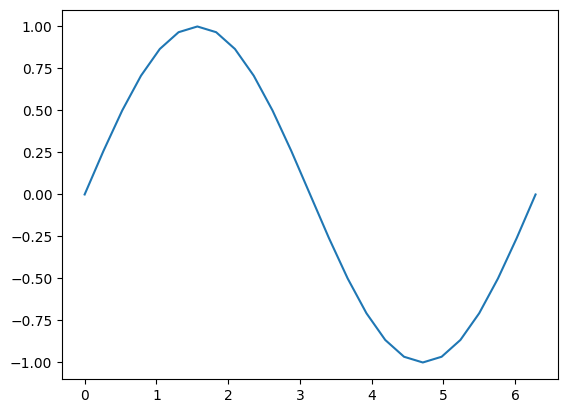

In [16]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Let's have a closer look at the tensor `b`. When we print it, we see an indicator that it is tracking its computation history:

In [17]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


This `grad_fn` gives us a hint that when we execute the backpropagation step and compute gradients, we'll need to compute the derivative of $sin(x)$ for all this tensor's inputs.

Let's perform some more computations:

In [18]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let's compute a single-element output. When you call `.backward()` on a tensor with no arguments, it expects the calling tensor to contain only a single element, as is the case when computing a loss function.

In [19]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Each `grad_fn` stored with our tensors allows you to walk the computation all the way back to its inputs with its `next_functions` property. We can see below that drilling down on this property on `d` shows us the gradient functions for all the prior tensors. Note that `a.grad_fn` is reported as `None`, indicating that this was an input to the function with no history of its own.

In [20]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x177e21a30>, 0), (None, 0))
((<SinBackward0 object at 0x177e21bb0>, 0), (None, 0))
((<AccumulateGrad object at 0x177e21af0>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You call the `backward()` method on the output, and check the input's `grad` property to inspect the gradients:

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


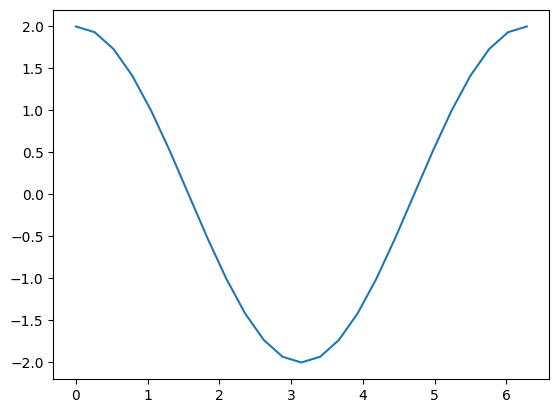

In [21]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

Recall the computation steps we took to get here:

```
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()
```

Adding a constant, as we did to compute `d`, does not change the derivative. That leaves $c = 2 * b = 2 * sin(a)$, the derivative of which should be $2 * cos(a)$. Looking at the graph above, that's just what we see.

Be aware than only *leaf nodes* of the computation have their gradients computed. If you tried, for example, `print(c.grad)` you'd get back `None`. In this simple example, only the input is a leaf node, so only it has gradients computed.


## **Building a Neural Network**

In [23]:
class BasicNN(nn.Module): 
    def __init__(self):
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False) 
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False) 
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    def forward(self, input): 

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        
        output = F.relu(input_to_final_relu)

        return output

In [24]:
# set up the model instance
neural_net_model = BasicNN()

# generate random values for input vector (tensor)
X = torch.linspace(start=0, end=1, steps=10)
print(X)

# set the tensor with labels 
y = torch.tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0])

print(y)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0])


In [25]:
# train the network - tune the final bias with backpropagation
optimizer = optim.SGD(neural_net_model.parameters(), lr=0.1)

print("Final bias, before optimisation: " + str(neural_net_model.final_bias) + "\n")

for epoch in range(0,100): 

    total_loss = 0 

    for iteration in range(len(X)): 
        input_i = X[iteration]
        label_i = y[iteration]

        output_i = neural_net_model(input_i)

        loss = (output_i - label_i)**2

        loss.backward()

        total_loss += float(loss)
    
    if (total_loss < 0.000001): 
        print("Number of steps: " + str(epoch))
        break


    optimizer.step()
    optimizer.zero_grad()

    print("Step: " + str(epoch) + " Final bias: " + str(neural_net_model.final_bias.data) + "\n")


Final bias, before optimisation: Parameter containing:
tensor(0., requires_grad=True)

Step: 0 Final bias: tensor(-14.0853)

Step: 1 Final bias: tensor(-14.2845)

Step: 2 Final bias: tensor(-14.4041)

Step: 3 Final bias: tensor(-14.4758)

Step: 4 Final bias: tensor(-14.5188)

Step: 5 Final bias: tensor(-14.5446)

Step: 6 Final bias: tensor(-14.5601)

Step: 7 Final bias: tensor(-14.5694)

Step: 8 Final bias: tensor(-14.5750)

Step: 9 Final bias: tensor(-14.5783)

Step: 10 Final bias: tensor(-14.5803)

Step: 11 Final bias: tensor(-14.5815)

Step: 12 Final bias: tensor(-14.5822)

Step: 13 Final bias: tensor(-14.5827)

Step: 14 Final bias: tensor(-14.5829)

Step: 15 Final bias: tensor(-14.5831)

Step: 16 Final bias: tensor(-14.5832)

Step: 17 Final bias: tensor(-14.5832)

Step: 18 Final bias: tensor(-14.5833)

Step: 19 Final bias: tensor(-14.5833)

Step: 20 Final bias: tensor(-14.5833)

Step: 21 Final bias: tensor(-14.5833)

Step: 22 Final bias: tensor(-14.5833)

Step: 23 Final bias: tenso

## **Torchvision Transforms**

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [28]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.



In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [30]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [31]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2], device='mps:0')
